En la clase anterior, vimos como la aleatoriedad ayuda a escapar de óptimos locales. Sin embargo, es posible que eso no sea suficiente. Tabú Search y Simmulated Annealing son dos metaheurísticas locales (parten de una solución inicial y van explorando) que se centran en escapar de óptimos locales: 

- Simmulated Annealing va aceptando empeoramientos con probabilidad decreciente, inspirado en el proceso físico de enfriamiento de metales.
- Tabú search prohibe movimientos recientes, teniendo memoria de cada uno de sus movimientos.

# Coloración de grafos 

Dado un grafo $G=(V,E)$ queremos asignar a cada vértice $v\in V$ un color $c(v)\in\lbrace 1,\dots,k\rbrace$ de modo que **ninguna arista** $(u,v)\in E$ tenga extremos del mismo color: 

$$c(u)\neq c(v)\;\;\;\forall (u,v)\in E$$ 

Para un $k\geq 3$ el problema es **NP-completo**. 

Este problema se ocupa principalmente en *scheduling* y *timetabling*. Imaginemos que debemos fijar un calendario para exámenes. Los vértices serían los ramos y las aristas determinan si comparten estudiantes. Así, los colores llegarían a ser los bloques de tiempo.

Por el otro lado, un ejemplo clásico de *scheduling* sería tener los vértices como trabajos y aristas si no pueden ejecutarse simultáneamentes. Los colores llegarían a ser slots o máquinas. 

Para este problema trabajaremos con la instancia `gcol15` [otorgada por OR-tools](https://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/). Este problema se clasifica como uno de dificultad media. A continuación, dos funciones auxiliares para leer y graficar las instancias.

In [1]:
# ======================================================================
# Utilidades para leer instancias DIMACS de coloring y graficar
# ======================================================================

import math
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


# ----------------------------------------------------------------------
# 1) Lector DIMACS (formato típico de OR-Tools / gcol*)
# ----------------------------------------------------------------------
def load_or_tools_col(path, relabel_zero_based=True):
    """
    Lee un archivo de coloración de grafos en formato DIMACS.
    Formato esperado (líneas típicas):
      - 'c ...'                  -> comentarios (se ignoran)
      - 'p edge n m'             -> cabecera, con n = #nodos, m = #aristas
      - 'e u v'                  -> arista entre u y v (índices 1..n)

    Parámetros
    ----------
    path : str
        Ruta al archivo (por ejemplo 'gcol15.txt').
    relabel_zero_based : bool
        Si es True, re-etiqueta los nodos a 0..n-1 (útil para trabajar con arrays).

    Retorna
    -------
    G : networkx.Graph
        Grafo simple no dirigido, sin pesos.
    meta : dict
        Información auxiliar: {'n', 'm', 'one_indexed', 'path'}.
    """
    n = None  # número de nodos declarado en la cabecera (si existe)
    m = None  # número de aristas declarado en la cabecera (si existe)
    edges = []  # acumularemos las aristas aquí

    # Abrimos el archivo línea por línea
    with open(path, "r", encoding="utf-8") as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue  # saltar líneas vacías
            if line.startswith("c"):
                continue  # saltar comentarios

            if line.startswith("p"):
                # Ejemplo: "p edge 100 2528"
                parts = line.split()
                # Buscamos los dos últimos números como n y m (robusto ante espacios extra)
                # Si el archivo usa "p edge n m", deberíamos tener al menos 4 tokens.
                if len(parts) >= 4:
                    # Normalmente: parts = ["p", "edge", n, m]
                    n = int(parts[-2])
                    m = int(parts[-1])
                else:
                    raise ValueError("Cabecera 'p' inválida: " + line)
                continue

            if line.startswith("e"):
                # Ejemplo: "e 1 2" -> arista (1,2)
                parts = line.split()
                # Esperamos al menos 3 tokens: ['e', 'u', 'v']
                if len(parts) >= 3:
                    u = int(parts[1])
                    v = int(parts[2])
                    edges.append((u, v))
                continue

    # Si no hubo cabecera 'p', inferimos n como el máximo índice que apareció
    if n is None:
        if not edges:
            raise ValueError("No se encontraron aristas ni cabecera 'p'.")
        n = max(max(u, v) for (u, v) in edges)
        m = len(edges)
    else:
        # Si hubo 'p', m podría no coincidir con len(edges) (no es grave para construir el grafo)
        if m is None:
            m = len(edges)

    # Construimos un grafo etiquetado 1..n (como dicta DIMACS)
    G = nx.Graph()
    G.add_nodes_from(range(1, n + 1))
    G.add_edges_from(edges)

    meta = {"n": n, "m": m, "one_indexed": True, "path": path}

    # re-etiquetar a 0..n-1, que es cómodo para arrays numpy
    if relabel_zero_based:
        mapping = {u: u - 1 for u in G.nodes()}
        G = nx.relabel_nodes(G, mapping, copy=True)
        meta["one_indexed"] = False

    return G, meta


def to_color_array(colors, n):
    """
    Convierte 'colors' a un arreglo numpy de enteros de largo n (o None).
    Acepta:
      - dict {nodo: color}  (nodos 0..n-1)
      - lista/array con el color de cada nodo en orden 0..n-1
      - None  -> devuelve None

    Notas:
      - No valida si los colores están en [0..k-1]; aquí sólo normalizamos formato.
      - Para grafos re-etiquetados a 0..n-1, esto es lo más práctico.
    """
    if colors is None:
        return None

    # Si es un diccionario {nodo: color}, lo volcamos a un array
    if isinstance(colors, dict):
        arr = np.zeros(n, dtype=int)
        for u, c in colors.items():
            arr[int(u)] = int(c)
        return arr

    # Si es lista/tupla/array, nos aseguramos que sea numpy.int y del largo n
    arr = np.asarray(list(colors), dtype=int)
    if arr.size != n:
        raise ValueError(f"'colors' debe tener largo n={n}, se obtuvo {arr.size}.")
    return arr


def count_conflicts(G, color_arr):
    """
    Cuenta el número de aristas en conflicto (extremos con el mismo color).
    """
    # Recorremos todas las aristas y comparamos el color de sus extremos
    cnt = 0
    for u, v in G.edges():
        if color_arr[u] == color_arr[v]:
            cnt += 1
    return cnt


def _pick_palette(k):
    """
    Construye una lista de 'k' colores (hex) para pintar nodos por clase/color.
    Usamos la paleta 'tab20' de matplotlib repetida si hiciera falta.
    """
    import matplotlib  # lo importamos aquí para no llenar el espacio global

    base = matplotlib.colormaps.get_cmap("tab20").colors  # paleta de 20 colores
    # Si k > 20, repetimos la paleta las veces necesarias
    repeticiones = int(math.ceil(k / float(len(base))))
    colores_hex = []
    for _ in range(repeticiones):
        for rgb in base:
            colores_hex.append(matplotlib.colors.to_hex(rgb))
    return colores_hex[:k]  # nos quedamos con los primeros k


def draw_coloring(
    G,
    colors=None,  # dict {nodo: color} o lista/array por índice
    k=None,  # nº de colores (si None, se infiere del máximo en 'colors')
    highlight_conflicts=True,  # si True, dibuja aristas en conflicto en rojo
    node_size=None,  # tamaño de los nodos (si None, se escala con n)
    edge_alpha=0.5,  # opacidad de aristas
    pos=None,  # layout (dict nodo -> (x,y)); si None, se calcula
    seed=42,  # semilla para el layout
    with_labels=False,  # si True, escribe el id de cada nodo (útil en grafos chicos)
):
    """
    Dibuja el grafo 'G' y, opcionalmente, un coloreo sobre sus nodos.
    Si se entrega 'colors', además puede resaltar en rojo las aristas en conflicto.
    Devuelve (fig, ax, pos) por si el usuario quiere reutilizar el layout.

    """
    n = G.number_of_nodes()

    # Normalizamos 'colors' a un array numpy o dejamos None si no se entregó
    color_arr = to_color_array(colors, n) if colors is not None else None

    # Si no nos dicen el tamaño de los nodos, definimos uno "decente" según n
    if node_size is None:
        if n <= 120:
            node_size = 300
        else:
            # a mayor n, hacemos el nodo más pequeño para que no tape todo
            node_size = max(40, int(12000 / n))

    # Si no nos dan un layout, usamos spring_layout (fuerzas) con semilla fija
    if pos is None:
        pos = nx.spring_layout(G, seed=seed)  # k por defecto (automático)

    # Creamos la figura y un eje
    fig, ax = plt.subplots(figsize=(8, 6))

    # 1) Primero dibujamos TODAS las aristas en gris claro (fondo)
    nx.draw_networkx_edges(
        G, pos, ax=ax, width=0.6, alpha=edge_alpha, edge_color="#bbbbbb"
    )

    # 2) Ahora dibujamos los nodos: con o sin colores según 'colors'
    if color_arr is None:
        # Sin coloreo: todos los nodos del mismo color azul
        nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_size=node_size,
            node_color="#4477aa",
            linewidths=0.5,
            edgecolors="white",
        )
        title = f"Grafo: n={n}, m={G.number_of_edges()}"
    else:
        # Con coloreo: asignamos una paleta
        if k is None:
            # Si no nos pasan k, lo inferimos del máximo color observado (+1)
            k = int(color_arr.max()) + 1
        palette = _pick_palette(k)
        # Construimos la lista de colores de cada nodo según su clase/color
        node_colors = [palette[int(c)] for c in color_arr]

        nx.draw_networkx_nodes(
            G,
            pos,
            ax=ax,
            node_size=node_size,
            node_color=node_colors,
            linewidths=0.5,
            edgecolors="white",
        )

        # Resaltar conflictos: aristas cuyos extremos tienen el mismo color
        conflictos = 0
        if highlight_conflicts:
            conflict_edges = []
            for u, v in G.edges():
                if color_arr[u] == color_arr[v]:
                    conflict_edges.append((u, v))
            conflictos = len(conflict_edges)
            if conflict_edges:
                nx.draw_networkx_edges(
                    G,
                    pos,
                    edgelist=conflict_edges,
                    ax=ax,
                    width=1.2,
                    alpha=0.9,
                    edge_color="#d62728",  # rojo para conflictos
                )

        title = f"Coloreo con k={k} | conflictos={conflictos} | n={n}, m={G.number_of_edges()}"

    # 4) Etiquetas de nodos (para grafos pequeños es útil)
    if with_labels and n <= 200:
        nx.draw_networkx_labels(G, pos, ax=ax, font_size=8)

    # 5) Detalles finales de la figura
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    return fig, ax, pos

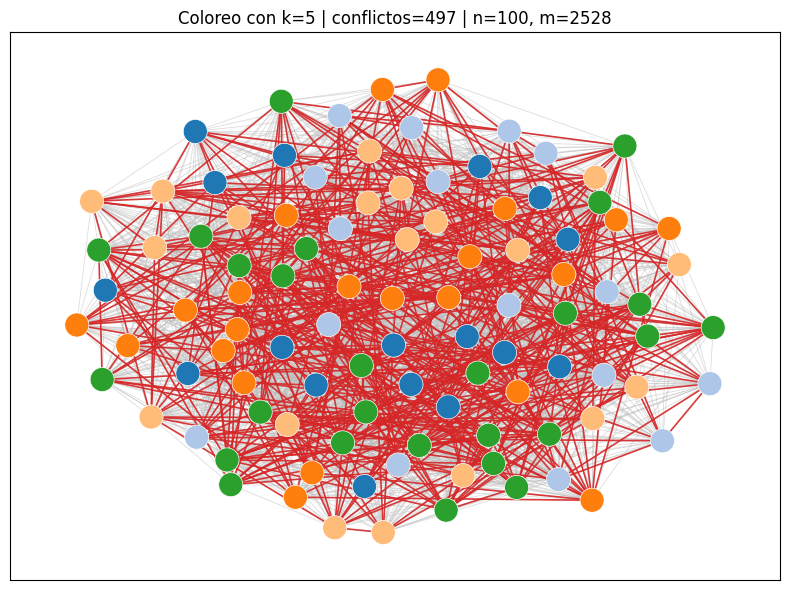

In [2]:
G, meta = load_or_tools_col("../data/gcol15.txt", relabel_zero_based=True)

rng = np.random.default_rng(7)
k_demo = 5
colors_demo = rng.integers(
    0, k_demo, size=G.number_of_nodes()
)  # Elegimos colores aleatoriamente

fig, ax, pos = draw_coloring(
    G, colors=colors_demo, k=k_demo, highlight_conflicts=True, with_labels=False
)
plt.show()

En este problema, el Tabú Search intentaría ir cambiando los colores, incluso aceptando soluciones peores. La gracia está en que si un movimiento se efectúa, entonces no se podrá revertir tal movimiento por `tenure` iteraciones, a no ser que el movimiento mejore la mejor solución encontrada hasta el momento. 

Así, partiendo de una solución inicial, nos paramos en un vértice y evaluamos cuál es el mejor vecino para cambiar el color. Añadimos a la lista el movimiento que hicimos tal que no se puede revertir por `tenure` iteraciones y repetimos. Vamos a parar si llegamos a tener 0 conflictos o llegamos a `max_iter`. 

In [3]:
def tabu_coloring(
    G, k, colors_init=None, max_iter=1500, tenure=10, seed=0, verbose=True
):
    """
    Tabu Search para k-coloring

    Parámetros
    ----------
    G : networkx.Graph
    k : int
        Cantidad de colores a trabajar
    colors_init : dict|array|None
       El punto inicial, si no se le pasa nada, parte de un punto aleatorio
    max_iter : int
        Cantidad máxima de iteraciones
    tenure : int
        Tamaño de la lista de movimientos prohibidos
    seed : int
    verbose : bool

    Retorna
    -------
    dict con:
      'best_conflicts' : int
      'colors_best'    : dict {nodo: color}
      'history'        : lista de conflictos actuales por iter
      'best_history'   : lista del mejor global por iter
    """
    rng = np.random.default_rng(seed)

    nodes = list(G.nodes())
    n = len(nodes)
    pos_of = {u: i for i, u in enumerate(nodes)}
    nbrs = [[pos_of[v] for v in G[u]] for u in nodes]

    # -----
    # Inicialización
    # -----
    if colors_init is None:
        colors = rng.integers(0, k, size=n, dtype=int)
        if verbose:
            print("[Init] aleatorio.")
    else:
        if isinstance(colors_init, dict):
            colors = np.zeros(n, dtype=int)
            for u in nodes:
                if u not in colors_init:
                    raise ValueError(
                        f"colors_init (dict) no trae color para el nodo {u}"
                    )
                colors[pos_of[u]] = int(colors_init[u])
        else:
            colors = np.asarray(list(colors_init), dtype=int)
            if colors.size != n:
                raise ValueError(
                    f"colors_init debe tener largo n={n}, se obtuvo {colors.size}."
                )

        cmin, cmax = int(colors.min()), int(colors.max())
        if cmin < 0 or cmax >= k:
            raise ValueError(
                f"Los colores iniciales deben estar en [0..{k-1}] (observado [{cmin}..{cmax}])."
            )
        if verbose:
            print("[Init] usando punto inicial entregado.")

    # -----
    # Funciones auxiliares
    # -----
    def conflicts_of(arr):
        cnt = 0
        for u, v in G.edges():
            if arr[pos_of[u]] == arr[pos_of[v]]:
                cnt += 1
        return cnt

    def delta_if_recolor(i, new_c):
        old_c = colors[i]
        if new_c == old_c:
            return 0
        same_old = 0
        same_new = 0
        for j in nbrs[i]:
            cj = colors[j]
            if cj == old_c:
                same_old += 1
            if cj == new_c:
                same_new += 1
        return same_new - same_old  # <0 mejora

    # -----
    # Estado inicial
    # -----
    curr_conf = conflicts_of(colors)
    best_conf = curr_conf
    best_colors = colors.copy()

    history = [curr_conf]
    best_history = [best_conf]

    # matriz tabú: hasta qué iter está prohibido (i -> color c)
    tabu_until = np.zeros((n, k), dtype=int)

    if verbose:
        print(f"[Init] k={k} | conflictos iniciales={curr_conf}")

    # -----
    # Loop principal
    # -----
    for it in range(1, max_iter + 1):
        best_move = None
        best_delta = +(10**9)  # buscamos el MÁS NEGATIVO (mejor mejora)

        # explorar todo el vecindario
        for i in range(n):
            old_c = colors[i]
            for new_c in range(k):
                if new_c == old_c:
                    continue

                delta = delta_if_recolor(i, new_c)
                is_tabu = tabu_until[i, new_c] > it

                # aspiración: permitir si mejora el mejor global
                if is_tabu and (curr_conf + delta >= best_conf - 1e-12):
                    continue

                if (delta < best_delta - 1e-12) or (
                    abs(delta - best_delta) <= 1e-12 and rng.random() < 0.5
                ):
                    best_delta = delta
                    best_move = (i, new_c)

        if best_move is None:
            if verbose:
                print(f"[Iter {it}] sin movimiento admisible; paro.")
            break

        # aplicar movimiento
        i, new_c = best_move
        old_c = colors[i]
        colors[i] = new_c
        curr_conf += best_delta

        # actualizar tabú: no volver a old_c por 'tenure' + un número aleatorio
        tabu_until[i, old_c] = it + tenure + rng.integers(0, 3)

        # actualizar mejor global
        if curr_conf < best_conf - 1e-12:
            best_conf = curr_conf
            best_colors = colors.copy()

        history.append(curr_conf)
        best_history.append(best_conf)

        if verbose and (it % 50 == 0 or it == 1):
            print(f"[Iter {it}] curr={curr_conf} | best={best_conf}")

        if best_conf == 0:
            if verbose:
                print(f"[OK] k-coloración válida encontrada en iter {it}.")
            break

    colors_best = {nodes[i]: int(best_colors[i]) for i in range(n)}
    return {
        "best_conflicts": int(best_conf),
        "colors_best": colors_best,
        "history": history,
        "best_history": best_history,
    }

A continuación evaluaremos el efecto de `tenure`. En específico, nos interesaría saber como se comporta tabú search con tenure cero (es decir, sin la lista de pasos prohibidos) y con valores más altos. *¿Realmente ayuda la restricción de movimientos para óptimos locales?*

A continuación, intentaremos resolver el mismo problema con **Simulated Annealing**. 

La idea es partir de una solución $s$ y una temperatura $T>0$. En cada paso, generamos un vecino $s'$. Si el vecino mejora nuestra solución, lo aceptamos; si lo empeora, lo aceptamos con probabilidad Metropolis: 

$$P(\text{aceptar})=\exp\left(-\frac{\Delta}{T}\right)$$ 

Donde $\Delta$ llegaría a ser el margen con el que se empeora el valor objetivo. 

La temperatura la iremos aumentando, tal que al final de las iteraciones será muy difícil aceptar una solución mala. 

Por lo mismo, Simulated Annealing nos ayudará a escapar de soluciones locales y luego quedarnos plantados en el nuevo punto óptimo.

A continuación tienen la función `simulated_annealing` , que recibe los siguientes parámetros: 

- `G`: El grafo de entrada
- `k`: La cantidad de colores a resolver
- `schedule`: La forma en que la temperatura va decayendo. Se tienen las siguientes opciones:
  * `geom`: Corresponde a una serie geométrica:
$$T_{t+1}=T_t\cdot\text{decay}$$ 
  * `exp`: Decae en función de una exponencial con respecto la iteración
$$T_{t+1}=T_0\cdot\exp(-\text{decay}\cdot t)$$
  * `arith`: Decae de forma aritmética
$$T_{t+1}=T_t-\text{decay}$$
- `init_temp`: Temperatura inicial
- `decay`: Razón de pérdida de temperatura
- `max_attempts`: Cantidad de intentos a realizar sin recibir ninguna mejora. Si no hay mejora en `max_attempts` iteraciones, paramos.
- `max_iters`: Tope global de iteraciones
- `seed`: Semilla aleatoria
- `verbose`: Añadir prints

In [9]:
import mlrose_hiive as mlrose


def simulated_annealing(
    G,
    k,
    schedule="geom",  # "geom" | "exp" | "arith"
    init_temp=5.0,
    decay=0.995,  # geom/exp: razón; arith: decremento
    min_temp=1e-3,
    max_attempts=200,  # intentos sin mejora por nivel
    max_iters=20000,  # tope global
    seed=0,
    verbose=True,
):
    """
    Ejecuta Simulated Annealing para k-coloring.

    Parámetros:
    -----------
    G: networkx.Graph

    k: int
        número de colores (0..k-1).

    schedule: str | geom
        Puede ser "geom", "exp" o "arith". Determina como se va enfriando la temperatura

    init_temp: float | 5.0
        Temperatura inicial, mientras más alta, más abierta está a probar movimientos nuevos

    decay: float | 0.995
        Tasa de enfriamento

    max_attempts: int | 200
        Si pasan `max_attempts` iteraciones sin mejorar, el algoritmo se detiene

    max_iters: int | 20000
        Tope global de iteraciones

    seed: int | 0
        Semilla

    verbose: bool | True
        Añadir prints en la ejecución


    Retorna:
    --------
    dict:
      - 'best_conflicts': int (# aristas con extremos del mismo color)
      - 'colors': {nodo: color}
      - 'curve': np.ndarray (historia del fitness)
      - 'k': k usado
    """

    # -----
    # Asegurar el mapeo 0..n-1 para mlrose
    # -----
    nodes = list(G.nodes())
    n = len(nodes)
    need_relabel = set(nodes) != set(range(n))
    if need_relabel:
        mapping = {u: i for i, u in enumerate(nodes)}
        G_work = nx.relabel_nodes(G, mapping, copy=True)
        rev = {i: u for u, i in mapping.items()}
    else:
        G_work = G
        rev = {i: i for i in range(n)}

    # -----
    # Pasar el problema a MLRose
    # -----
    edges = list(G_work.edges())
    fitness = mlrose.MaxKColor(edges)  # fitness = #conflictos (minimizar)
    problem = mlrose.DiscreteOpt(
        length=n, fitness_fn=fitness, maximize=False, max_val=k
    )

    # -----
    # Forma en que determinaremos el enfriamiento
    # -----
    if schedule == "geom":
        sch = mlrose.GeomDecay(init_temp=init_temp, decay=decay, min_temp=min_temp)
    elif schedule == "exp":
        sch = mlrose.ExpDecay(init_temp=init_temp, exp_const=decay, min_temp=min_temp)
    elif schedule == "arith":
        sch = mlrose.ArithDecay(init_temp=init_temp, decay=decay, min_temp=min_temp)
    else:
        raise ValueError("schedule debe ser 'geom' | 'exp' | 'arith'.")

    # -----
    # Simulated Annealing: llamar a la función
    # -----
    best_state, best_conflicts, curve = mlrose.simulated_annealing(
        problem,
        schedule=sch,
        max_attempts=max_attempts,
        max_iters=max_iters,
        curve=True,
        random_state=seed,
    )

    # -----
    # Reconstruir colores por nodo original
    # -----
    colors_idx = {i: int(best_state[i]) for i in range(n)}
    colors = {rev[i]: c for i, c in colors_idx.items()}

    if verbose:
        print(
            f"[SA k={k}] best_conflicts={int(best_conflicts)} | "
            f"coloreo_válido={bool(best_conflicts == 0)}"
        )

    return {
        "best_conflicts": int(best_conflicts),
        "colors": colors,
        "curve": curve,
        "k": k,
    }

Como podemos ver, unas de las gracias de `simulated_annealing` es que es muy personalizable. Así, queda propuesto **superar** al tabu search (50 conflictos, aproximadamente) en el problema del coloreo. Apóyense en el gráfico anterior para poder determinar una temperatura coherente con el problema. Además, grafiquen como evoluciona la mejor respuesta en función de las iteraciones. *¿Por qué creen que Simulated Annealing da mejor/peor que Tabu Search?*